In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

test['Survived'] = np.nan
main_data = pd.concat([train,test],ignore_index=True,sort=False)

In [3]:
main_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
main_data.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

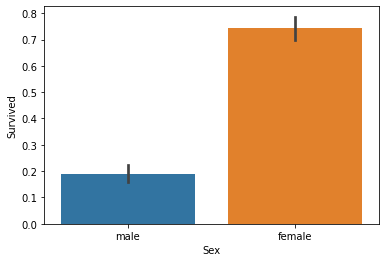

In [5]:
sns.barplot(x='Sex',y='Survived',data=main_data)
plt.show()

In [6]:
#----Predict Age-------------
from sklearn.ensemble import RandomForestRegressor

age_df = main_data[['Age','Pclass','Sex','Parch','SibSp']]
age_df=pd.get_dummies(age_df)

#Separate train and test data and convert to numpy array.
known_age = age_df[age_df.Age.notnull()].values
unknown_age = age_df[age_df.Age.isnull()].values

x = known_age[:,1:]
y = known_age[:,0]

model_age = RandomForestRegressor(random_state=0,n_estimators=100,n_jobs=-1)
model_age.fit(x,y)

predictedAges = model_age.predict(unknown_age[:,1::])

In [7]:
main_data.loc[(main_data.Age.isnull()),'Age'] = predictedAges

In [6]:
main_data.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

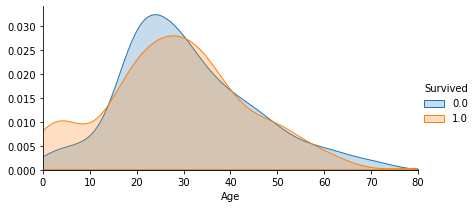

In [7]:
facet = sns.FacetGrid(main_data[0:890], hue="Survived",aspect=2)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, main_data.loc[0:890,'Age'].max()))
facet.add_legend()
plt.show()

In [8]:
df = main_data

<AxesSubplot:xlabel='Title', ylabel='Survived'>

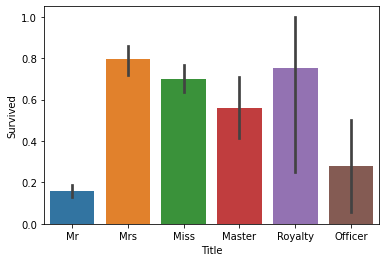

In [15]:
# Nameから敬称(Title)を抽出し、グルーピング
df['Title'] = df['Name'].map(lambda x: x.split(', ')[1].split('. ')[0])
df['Title'].replace(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer', inplace=True)
df['Title'].replace(['Don', 'Sir',  'the Countess', 'Lady', 'Dona'], 'Royalty', inplace=True)
df['Title'].replace(['Mme', 'Ms'], 'Mrs', inplace=True)
df['Title'].replace(['Mlle'], 'Miss', inplace=True)
df['Title'].replace(['Jonkheer'], 'Master', inplace=True)
sns.barplot(x='Title', y='Survived', data=df)

In [20]:
#Surname-----------------------------------------------------------
df['Surname'] = df['Name'].map(lambda name:name.split(',')[0].strip())
df['FamilyGroup'] = df['Surname'].map(df['Surname'].value_counts())

In [25]:
Female_Child_Group=df.loc[(df['FamilyGroup']>=2) & ((df['Age']<=16) | (df['Sex']=='female'))]
Female_Child_Group=Female_Child_Group.groupby('Surname')['Survived'].mean()
print(Female_Child_Group.value_counts())

1.000000    113
0.000000     32
0.750000      2
0.333333      1
0.142857      1
0.500000      1
Name: Survived, dtype: int64


In [29]:
Male_Child_Group=df.loc[(df['FamilyGroup']>=2) & ((df['Age']>16) | (df['Sex']=='male'))]
Male_Child_Group=Male_Child_Group.groupby('Surname')['Survived'].mean()
print(Male_Child_Group.value_counts())

0.000000    94
1.000000    62
0.500000    30
0.666667     9
0.333333     4
0.400000     2
0.250000     2
0.600000     1
0.750000     1
Name: Survived, dtype: int64


In [32]:
Dead_list = set(Female_Child_Group[Female_Child_Group.apply(lambda x:x==0)].index)
Survived_list = set(Male_Child_Group[Male_Child_Group.apply(lambda x:x==1)].index)

In [39]:
df.loc[(df['Survived'].isnull()) & (df['Surname'].apply(lambda x:x in Dead_list)),\
             ['Sex','Age','Title']] = ['male',28.0,'Mr']
df.loc[(df['Survived'].isnull()) & (df['Surname'].apply(lambda x:x in Survived_list)),\
             ['Sex','Age','Title']] = ['female',5.0,'Mrs']

In [50]:
#Fare----------------------------平均値にするとFareが整数にならないので、現実的でない四捨五入してもいいけど面倒.
farefill = df.loc[(df['Embarked'] == 'S') & (df['Pclass'] == 3),'Fare'].median()
df['Fare'].fillna(farefill,inplace=True)

In [53]:
# ----------- Family -------------
df['Family']=df['SibSp']+df['Parch']+1
df.loc[(df['Family']>=2) & (df['Family']<=4), 'Family_label'] = 2
df.loc[(df['Family']>=5) & (df['Family']<=7) | (df['Family']==1), 'Family_label'] = 1  # == に注意
df.loc[(df['Family']>=8), 'Family_label'] = 0

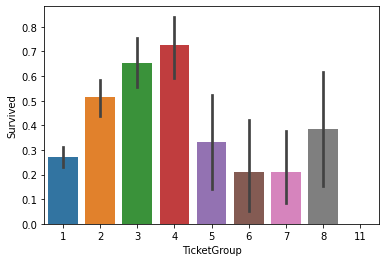

In [56]:
# ----------- Ticket ----------------
# 同一Ticketナンバーの人が何人いるかを特徴量として抽出
Ticket_Count = dict(df['Ticket'].value_counts())
df['TicketGroup'] = df['Ticket'].map(Ticket_Count)
sns.barplot(x='TicketGroup', y='Survived', data=df)
plt.show()

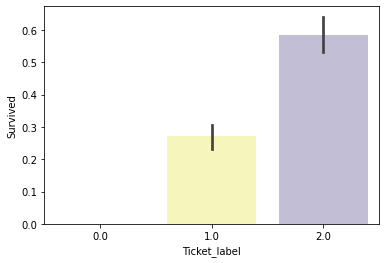

In [57]:
# 生存率で3つにグルーピング
df.loc[(df['TicketGroup']>=2) & (df['TicketGroup']<=4), 'Ticket_label'] = 2
df.loc[(df['TicketGroup']>=5) & (df['TicketGroup']<=8) | (df['TicketGroup']==1), 'Ticket_label'] = 1  
df.loc[(df['TicketGroup']>=11), 'Ticket_label'] = 0
sns.barplot(x='Ticket_label', y='Survived', data=df, palette='Set3')
plt.show()

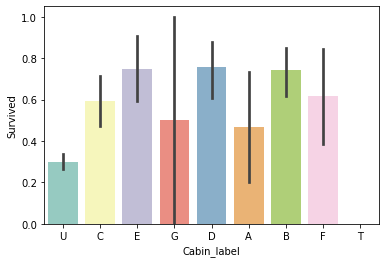

Unknown            1014
C23 C25 C27           6
G6                    5
B57 B59 B63 B66       5
C78                   4
                   ... 
C45                   1
A7                    1
B4                    1
E38                   1
C70                   1
Name: Cabin, Length: 187, dtype: int64

In [59]:
# ------------- Cabin ----------------
# Cabinの先頭文字を特徴量とする(欠損値は U )
df['Cabin'] = df['Cabin'].fillna('Unknown')
df['Cabin_label']=df['Cabin'].str.get(0)
sns.barplot(x='Cabin_label', y='Survived', data=df, palette='Set3')
plt.show()
df['Cabin'].value_counts()

In [60]:
# ---------- Embarked ---------------
df['Embarked'] = df['Embarked'].fillna('S') 

In [61]:
#One-hot-encoding
df = df[['Survived','Pclass','Sex','Age','Fare','Embarked','Title','Family_label','Cabin_label','Ticket_label']]

In [63]:
df = pd.get_dummies(df)

In [65]:
#devine train and test
train = df[df['Survived'].notnull()]
test = df[df['Survived'].isnull()].drop('Survived',axis=1)

In [80]:
X

array([[ 3.    , 22.    ,  7.25  , ...,  0.    ,  0.    ,  1.    ],
       [ 1.    , 38.    , 71.2833, ...,  0.    ,  0.    ,  0.    ],
       [ 3.    , 26.    ,  7.925 , ...,  0.    ,  0.    ,  1.    ],
       ...,
       [ 3.    ,     nan, 23.45  , ...,  0.    ,  0.    ,  1.    ],
       [ 1.    , 26.    , 30.    , ...,  0.    ,  0.    ,  0.    ],
       [ 3.    , 32.    ,  7.75  , ...,  0.    ,  0.    ,  1.    ]])

In [77]:
X = train.values[:,1:]  
y = train.values[:,0] 
test_x = test.values

In [78]:
#Create Model
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

In [79]:
#Select Best Feature
select = SelectKBest(k = 20)

clf = RandomForestClassifier(random_state = 10, 
                             warm_start = True,  # 既にフィットしたモデルに学習を追加 
                             n_estimators = 26,
                             max_depth = 6, 
                             max_features = 'sqrt')
pipeline = make_pipeline(select, clf)
pipeline.fit(X, y)

# フィット結果の表示
cv_result = cross_validate(pipeline, X, y, cv= 10)
print('mean_score = ', np.mean(cv_result['test_score']))
print('mean_std = ', np.std(cv_result['test_score']))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').